In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Bio import Entrez, SeqIO
from numpy.lib.stride_tricks import sliding_window_view
from sklearn import preprocessing

from meme2jaspar import read_meme_file


Entrez.email = "kuei.yueh.ko@duke.edu"

## Prepare PWM

In [4]:
!ls ./*meme

./HOCOMOCOv11_core_HUMAN_mono_meme_format.meme	       ./MA0727.1.meme
./JASPAR2018_CORE_vertebrates_non-redundant_pfms.meme


In [6]:
pwms_jsp = read_meme_file("./JASPAR2018_CORE_vertebrates_non-redundant_pfms.meme")
len(pwms_jsp)

579

In [14]:
pwms_hoc = read_meme_file("./HOCOMOCOv11_core_HUMAN_mono_meme_format.meme")
len(pwms_hoc)

401

In [15]:
def find_match(lst, query):
    fun = lambda x: query in x
    gen = filter(fun, lst)
    return list(gen)

In [16]:
lst = list(pwms_jsp.keys())
mtf = "MA0727.1"
find_match(lst, mtf)

['NR3C2_MA0727.1']

In [18]:
lst = list(pwms_jsp.keys())
mtf = "MA0113.3"
find_match(lst, mtf)

['NR3C1_MA0113.3']

In [20]:
lst = list(pwms_hoc.keys())
mtf = "PRGR_HUMAN.H11MO.0.A"
find_match(lst, mtf)

['PRGR_HUMAN.H11MO.0.A']

In [21]:
lst = list(pwms_hoc.keys())
mtf = "GCR_HUMAN.H11MO.0.A"
find_match(lst, mtf)

['GCR_HUMAN.H11MO.0.A']

In [24]:
pwms = list()
pwms.append(pwms_jsp['NR3C2_MA0727.1'])
pwms.append(pwms_jsp['NR3C1_MA0113.3'])
pwms.append(pwms_hoc['PRGR_HUMAN.H11MO.0.A'])
pwms.append(pwms_hoc['GCR_HUMAN.H11MO.0.A'])

fun = lambda x: x.shape
list(map(fun, pwms))

[(17, 4), (17, 4), (16, 4), (15, 4)]

## Prepare sequence

In [26]:
### init
gid = 568815581
loc_start = 8_151_163
loc_stop  = 8_152_064

### setup
handle = Entrez.efetch(
    db        = "nucleotide", 
    id        = gid, 
    rettype   = "fasta", 
    strand    = 1, 
    seq_start = loc_start, 
    seq_stop  = loc_stop)

### query
record = SeqIO.read(handle, "fasta")
handle.close()

### show results
print(record.seq)

GCCTCCAAGGCCTCGGAGCAGGAGGTGAGCTGGTCGCCTCCTATATTTAGGCCTCCAGGCTAATTTTATCCGGGGGCGGTGCCACCCCCGCTGCACATGCGCGCCGACGTGCGCGGCCCCACCACGCGCTTCCGCCGCCGCCACGGTCGCCAGGGAAACCGACGTCAGCTGCTGAGCTCAGCGGTTGCTGGAGGGACCACAGGAGGGCGGGAGGAGCGACCCCTCCCCCATTTCCCGGCGGAAGTGGGGGAACGGCCCACTCTCACACTGGTGGGCGCGGCCGGGGGGGTCACGCATCCCTTACATATCCCCAGTCCCAGGATGGCTCGGTGGCCGTAAGAAGTGGGACGGCCTATTAGGATCCCAGGGTTGGTCCTGGCTTCCCCAGGACGAAGCACAACGGCCACTGCCCTCGGCGCAAAAGCCCCTCAACCTGACTCTCGCCTGGATCCCAGTCATTCTGGTCAAGACAACACAACCTTTCCTTCTTTAGCCCCTGCGCTGCTTCCCCACCACAAGGACCGAAGCCGGCAACCTGCCATCGTCAAGGACCCGAGGATCCTCTCTCTTCAGTCCCCTACTTTTCTGGCCAGACCCCCCCACCAACCCCAAGCCTTGGGCAGAAGACACACAACAGCCAACAGATCTTTCTTCCCCTACTCCCCGTCCAACCACACCCCTACTACTGAGCATTTTCTGAGCGCCAGGGGAAAAGGGAAGGTTGTGGCCAACAGCAGGAACCAGCGCTGGGAACGGGATGTTCTAGTCCGAAGTGGGCTGACATCACAGGCGGCGCAGGGCCAGGGACTGGAGAACAGAGACACGGGGAGCGCTGAAAGCCTAATAGGGTCCTGGTACCGGGGCAAACCTGGGGCCCCTCGAGTAACGAGCAAGAAGACCGG


In [27]:
enc_lab = preprocessing.LabelEncoder()
enc_hot = preprocessing.OneHotEncoder(sparse=False)

seq_str = record.seq
seq_arr = np.array(list(seq_str))
seq_int = enc_lab.fit_transform(seq_arr)
seq_int = seq_int.reshape(-1, 1)
seq_hot = enc_hot.fit_transform(seq_int)

print(len(seq_str))
print(seq_arr.shape)
print(seq_int.shape)
print(seq_hot.shape)

902
(902,)
(902, 1)
(902, 4)


In [46]:
def conv(seq_hot, pwm):
    win = sliding_window_view(seq_hot, pwm.shape)
    res = win * pwm
    res = res.sum(axis=-1).sum(axis=-1).flatten()
    return res

lst = [conv(seq_hot, pwm) for pwm in pwms]
print(list(map(len, lst)))

min_len = min([len(x) for x in lst])
print(min_len)

fun = lambda x: x[:min_len]
arr = np.array(list(map(fun, lst)))
print(arr.shape)

#max_len = max([len(x) for x in lst])
#print(max_len)

#fun = lambda x: np.pad(x, (0, max_len-len(x)), 'constant')
#arr = np.array(list(map(fun, lst)))
#print(arr.shape)

[886, 886, 887, 888]
886
(4, 886)


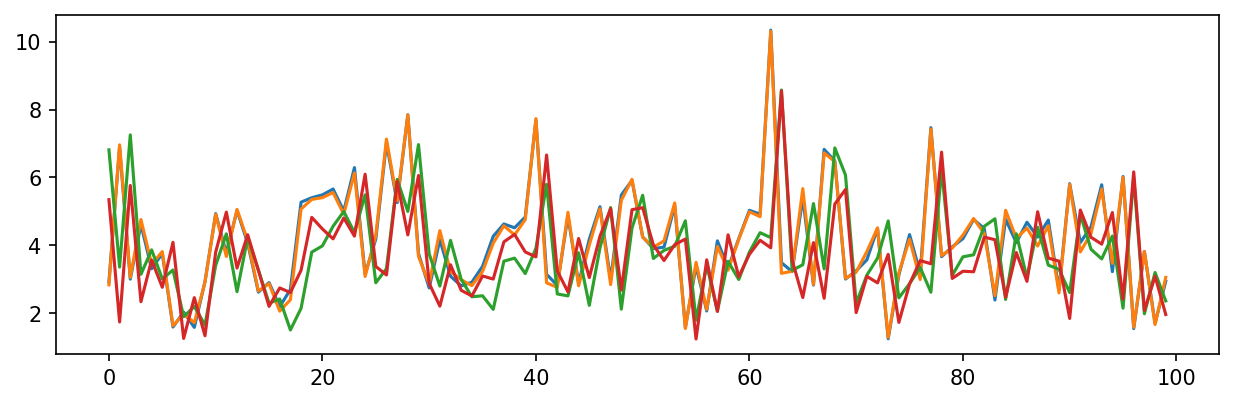

In [66]:
plt.figure(figsize=(10, 3), dpi=150)
for y in arr:
    plt.plot(y[-200:-100])

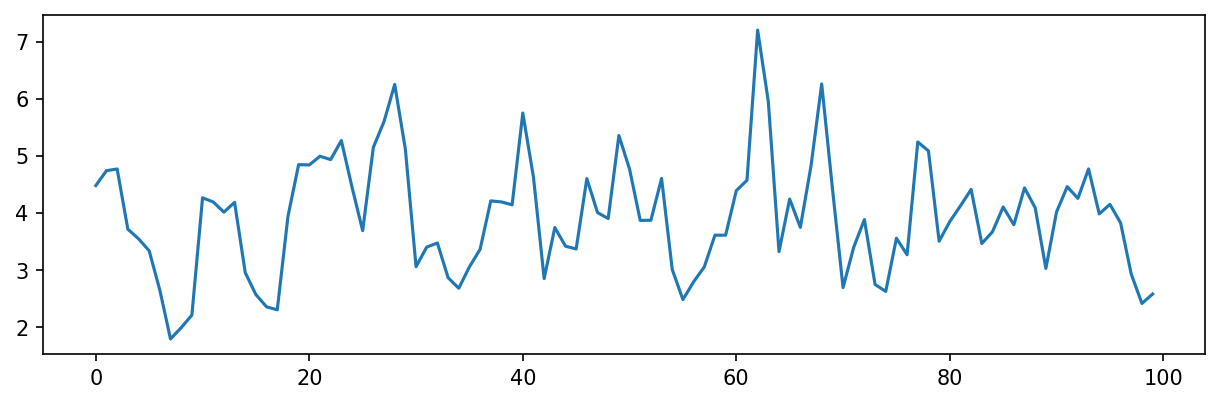

In [67]:
plt.figure(figsize=(10, 3), dpi=150)
y = arr.mean(axis=0)
plt.plot(y[-200:-100])